In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Activation,
                                    Flatten, Dense, Reshape, Dropout, Add, Input)
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
import random
import pickle
import sys

In [13]:
class AEUnet:
    @staticmethod
    def collin(dim=1024,depth=1,filters=(16,32,64,128,256,512), latentDepth=1024):
        '''
        dim: dim of square input image
        depth: number of channels in input image
        filters: tuple for set of convolution filters, defaulted to paper implementation
        latentDepth: depth of latent layer
        '''
        inputShape=(dim,dim,depth)
        chanDim=-1 #channel dimension (-1) applies batch norm for each layer (or depth) Unknowns=[mu(untrainable),sigma(untrainable),gamma,beta]*depth

        inputs = Input(shape=inputShape)
        x = inputs

        # generate:conv=>relu=>bn layers
        # additionally, save skip connections and add dropout
        # Dropout layers increase by 0.1 as the encoder gets deeper
        skips = []
        for i, f in enumerate(filters):
            x = Conv2D(f,(5,5),strides=2,padding='same')(x)
            x1 = [x]
            skips.append(x1[0])
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x) 
            x = Dropout(0.1 * i)(x)

        # For the UNet build, use a conv layer instead of dense for latent
        latent = Conv2D(latentDepth, (5, 5), strides=2, padding='same', name='latent')(x)
        y = latent
        
        #decode the latent space, incorporating skip layers
        for i, f in reversed(list(enumerate(filters))):
            y = Conv2DTranspose(f,(5,5),strides=2,padding='same')(y)
            y = Add()([skips[i], y])
            y = LeakyReLU(alpha=0.2)(y)
            y = BatchNormalization(axis=chanDim)(y)

        
        # Technically not strictly following the paper, this should be a straight-up upsampling
        y = Conv2DTranspose(depth,(5,5),strides=2,padding='same')(y)
        outputs = Activation('sigmoid')(y)
        autoencoder = Model(inputs,outputs,name='autoencoder')

        return autoencoder

    def mobilenet(output_channels, input_dim):

        base_model = tf.keras.applications.MobileNetV2(input_shape=[input_dim, input_dim, 3], include_top=False)

        # Use the activations of these layers
        layer_names = [
            'block_1_expand_relu',   # 64x64
            'block_3_expand_relu',   # 32x32
            'block_6_expand_relu',   # 16x16
            'block_13_expand_relu',  # 8x8
            'block_16_project',      # 4x4
        ]
        layers = [base_model.get_layer(name).output for name in layer_names]

        # Create the feature extraction model
        down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
        down_stack.trainable = True # From TLP experience, this should be True

        # "Add" layer version
        up_stack = [
            pix2pix.upsample(576, 3),  # 4x4 -> 8x8
            pix2pix.upsample(192, 3),  # 8x8 -> 16x16
            pix2pix.upsample(144, 3),  # 16x16 -> 32x32
            pix2pix.upsample(96, 3),   # 32x32 -> 64x64
        ]

#         # "Concat" layer version
#         up_stack = [
#             pix2pix.upsample(512, 3),  # 4x4 -> 8x8
#             pix2pix.upsample(256, 3),  # 8x8 -> 16x16
#             pix2pix.upsample(128, 3),  # 16x16 -> 32x32
#             pix2pix.upsample(64, 3),   # 32x32 -> 64x64
#         ]

        inputs = tf.keras.layers.Input(shape=[input_dim, input_dim, 3])
        x = inputs

        # Downsampling through the model
        skips = down_stack(x)
        x = skips[-1]
        skips = reversed(skips[:-1])

        # Upsampling and establishing the skip connections
        for up, skip in zip(up_stack, skips):
            x = up(x)
            # swap concat for add
            add = tf.keras.layers.Add()
            x = add([x, skip])

        # This is the last layer of the model
        last = tf.keras.layers.Conv2DTranspose(
            output_channels, 3, strides=2,
            padding='same')(x)  #64x64 -> 128x128

        # Modification to make autoencoder
        outputs = Activation('sigmoid')(last)
        autoencoder = Model(inputs,outputs,name='autoencoder')

        return autoencoder
    
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [122]:
# Configs
DIM = 256
DATA_DIR = 'data/mvtec_anomaly_detection/carpet/train/good/'
EPOCHS = 1000
INIT_LR = 1e-3
BS = 8
LOSS = 'mse'
testImg = 'data/mvtec_anomaly_detection/carpet/test/hole/000.png'
modelSavePath = 'prototype.pb'
def create_autoencoder():
    return AEUnet.mobilenet(3, DIM)

In [15]:
autoencoder = AEUnet.mobilenet(3, DIM)

In [110]:
from random import randint, uniform
from numpy.random import normal, uniform
from skimage.util import random_noise
from skimage.filters import threshold_otsu
from skimage.draw import ellipse_perimeter, disk
from scipy.interpolate import interp1d 
from scipy.ndimage import gaussian_filter

def add_stain(img,
              min_size=10,
              max_size=40,
              min_color=0.,
              max_color=255.,
              cx_range=None,
              cy_range=None,
              irregularity=0.08,
              blur=0.08):
    '''
    Draw an ellipse-like shape 
    INPUT : 
        - img: image to corrupt with an elliptical stain
        - min_size, max_size: bounds for stain size in percentage
        - min_color, max_color: bounds of intensities to sample from (0 - 255)
        - cx_range, cy_range: (optional) tuples to constrain location (in percentage of image) of stain center
        - irregularity: level of irregularity of the ellipse (0: no)
        - blur: blur edges (0: no)
    OUTPUT: 
        - corrupted image
    '''
    
    assert min_size <= max_size, 'min_size must not be greater than max_size'
    assert min_size >= 0 and max_size <= 100, 'invalid sizes. Must be in range [0, 100]'
    assert min_color <= max_color, 'min_color must not be greater than max_color'
    assert max_color >= 0 and max_color <= 255, 'invalid colors, Must be in range[0, 255]'

    color    = randint(min_color, max_color)
    col, row = img.shape[1], img.shape[0]
    rotation = uniform(0, 2*np.pi)
    ax_x = int(randint(min_size, max_size)/2 / 100*col)
    ax_y = int(randint(min_size, max_size)/2 / 100*row)
    
    if cx_range is not None:
        cx_lower = int(cx_range[0] / 100.*col)
        cx_upper = int(cx_range[1] / 100.*col)
    else:
        cx_lower = int(max_size/2 / 100.*col)
        cx_upper = int((100 - max_size/2) / 100.*col)
        
    if cy_range is not None:
        cy_lower = int(cy_range[0] / 100.*row)
        cy_upper = int(cy_range[1] / 100.*row)
    else:
        cy_lower = int(max_size/2 / 100.*row)
        cy_upper = int((100 - max_size/2) / 100.*row)
    
    cx, cy = randint(cx_lower, cx_upper), randint(cy_lower, cy_upper)
    y,x      = ellipse_perimeter(cy, cx, ax_y, ax_x, rotation)
    # Flip x and y because opencv is annoying
    contour  = np.array([[i,j] for i,j in zip(x,y)])
    # Change the shape of the ellipse 
    if irregularity > 0: 
        contour = _perturbate_ellipse(contour, cx, cy, (ax_x+ax_y)/2, irregularity)

    mask = np.zeros((row, col)) 
    mask = cv2.drawContours(mask, [contour], -1, 1, -1)

    if blur != 0 : 
        mask = gaussian_filter(mask, max(ax_x,ax_y)*blur)

    rgb_mask     = np.dstack([mask]*3)
    not_modified = np.subtract(np.ones(img.shape), rgb_mask)
    stain        = 255*random_noise(np.zeros(img.shape), mode='gaussian', mean = color/255., var = 0.05/255.)
    result       = np.add( np.multiply(img,not_modified), np.multiply(stain,rgb_mask) ) 

    return result.astype(np.uint8)

'''
Helper functions for stain
'''
def _perturbate_ellipse(contour, cx, cy, diag, irregularity):
    # Keep only some points
    if len(contour) < 20: 
        pts = contour
    else: 
        pts = contour[0::int(len(contour)/20)]

    # Perturbate coordinates
    for idx,pt in enumerate(pts): 
        pts[idx] = [pt[0]+randint(-int(diag*irregularity), int(diag*irregularity)),
                    pt[1]+randint(-int(diag*irregularity),int(diag*irregularity))]
    pts = sorted(pts, key=lambda p: _clockwiseangle(p, cx, cy))
    pts.append([pts[0][0], pts[0][1]])

    # Interpolate between remaining points
    i = np.arange(len(pts))
    interp_i = np.linspace(0, i.max(), 10 * i.max())
    yi = interp1d(i, np.array(pts)[:,0], kind='cubic')(interp_i)
    xi = interp1d(i, np.array(pts)[:,1], kind='cubic')(interp_i) 
 
    return np.array([[int(i),int(j)] for i,j in zip(yi,xi)])

def _clockwiseangle(point, cx, cy):
    refvec = [0 , 1]
    vector = [point[0]-cy, point[1]-cx]
    norm   = math.hypot(vector[0], vector[1])
    # If length is zero there is no angle
    if norm == 0:
        return -math.pi
    normalized = [vector[0]/norm, vector[1]/norm]
    dotprod    = normalized[0]*refvec[0] + normalized[1]*refvec[1] 
    diffprod   = refvec[1]*normalized[0] - refvec[0]*normalized[1] 
    angle      = math.atan2(diffprod, dotprod)
    if angle < 0:
        return 2*math.pi+angle
    return angle

In [111]:
def stain_wrapper(image, target):
    image = image.numpy()
    image = add_stain(image)
    return image.astype('float32') / 255, target

stain_lambda = lambda x, y: tf.py_function(stain_wrapper, [x, y], ['float32', 'float32'])

In [112]:
# data input pipeline
imgDir = os.listdir(DATA_DIR)
# Note: not grayscale!!!

imgs = np.empty((len(imgDir), DIM, DIM, 3), dtype='uint8')
for i, imgName in enumerate(imgDir):
    img = cv2.imread(os.path.join(DATA_DIR, imgName))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    imgs[i] = img

(trainX, valX)=train_test_split(imgs,test_size=0.2,random_state=42)

trainData = tf.data.Dataset.from_tensor_slices((trainX, trainX.astype('float32') / 255))\
            .prefetch(tf.data.experimental.AUTOTUNE)\
            .map(stain_lambda)\
            .shuffle(trainX.shape[0])\
            .batch(BS)
            
valData   = tf.data.Dataset.from_tensor_slices((valX, valX.astype('float32') / 255))\
            .prefetch(tf.data.experimental.AUTOTUNE)\
            .map(stain_lambda)\
            .batch(BS)

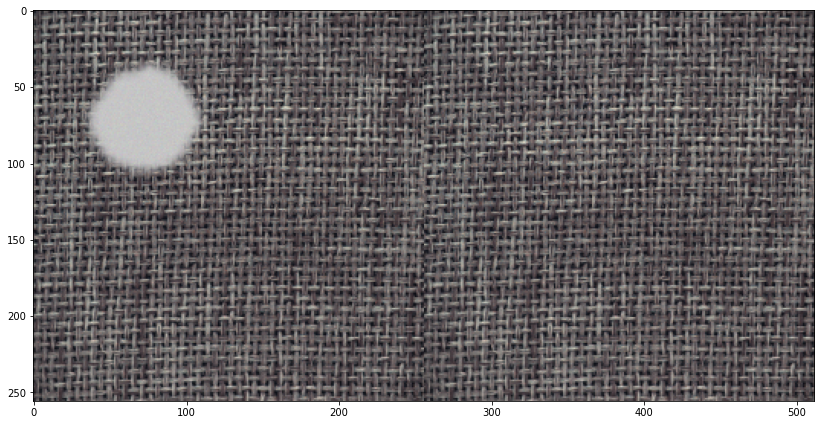

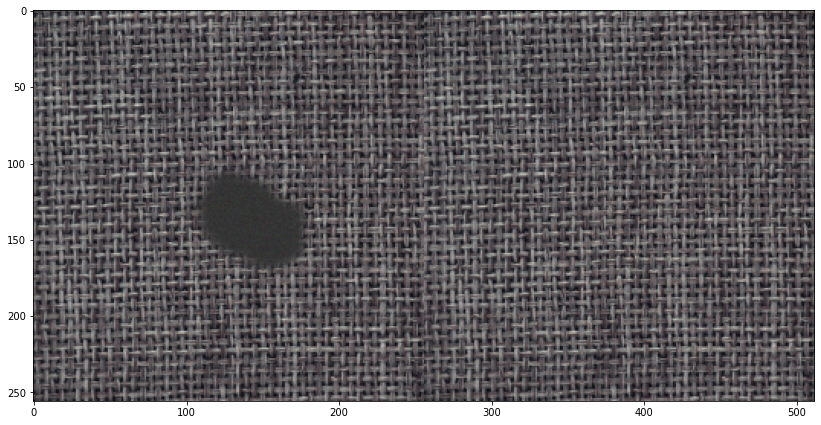

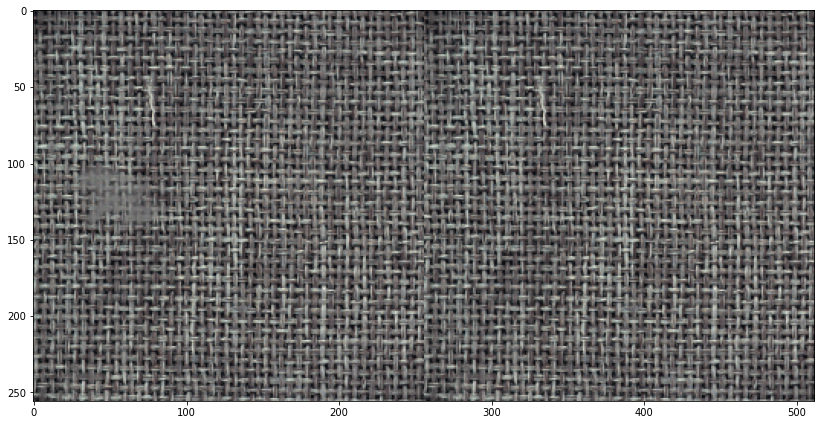

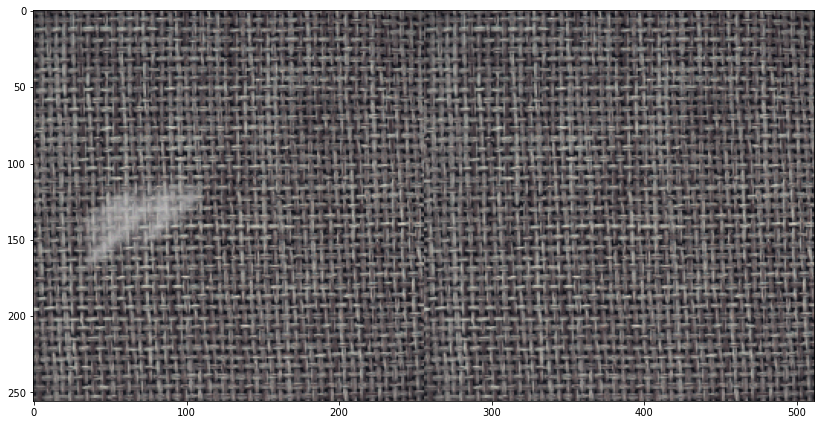

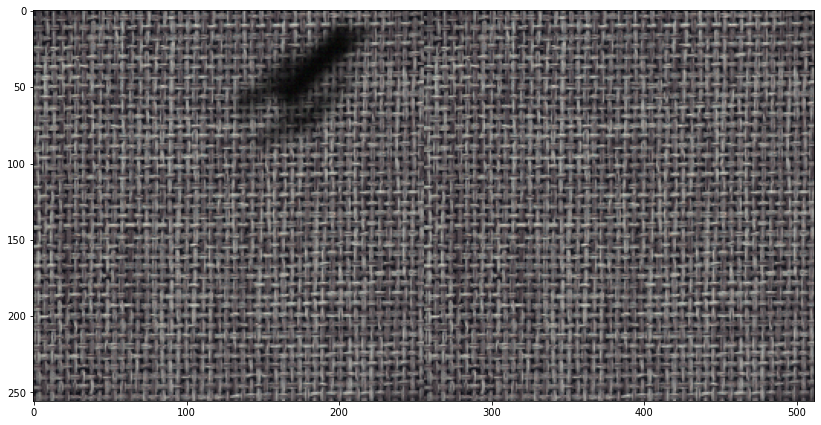

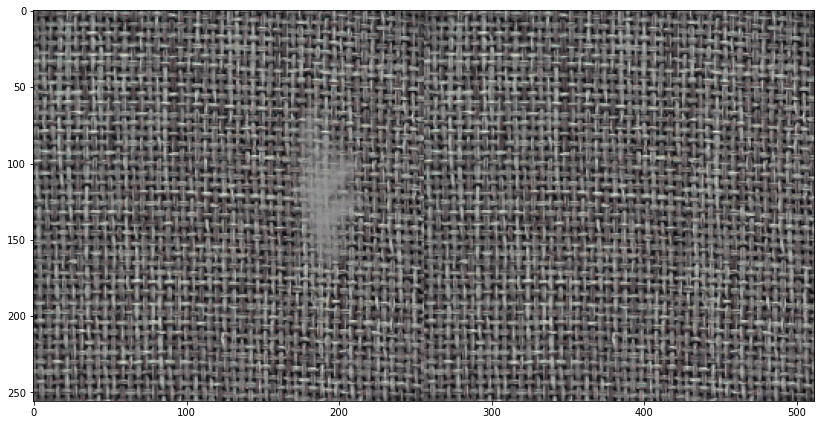

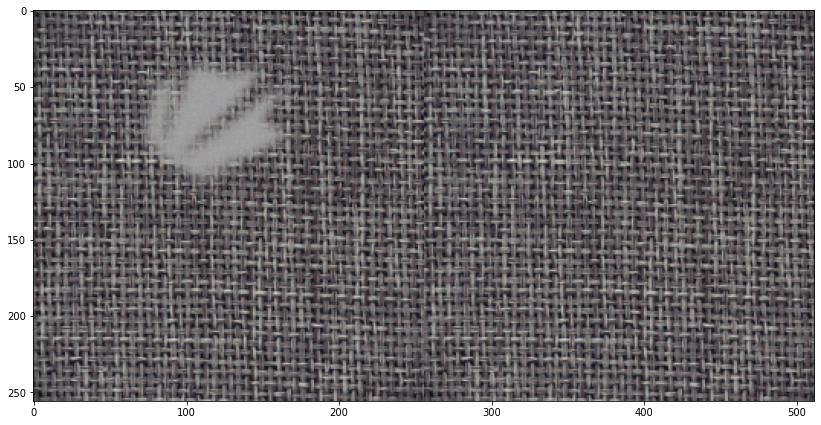

In [113]:
# Sanity check
for i, data in enumerate(trainData):
    plt.figure(figsize=(14,14))
    plt.imshow(np.hstack((data[0][0], data[1][0])))
    if i > 5:
        break

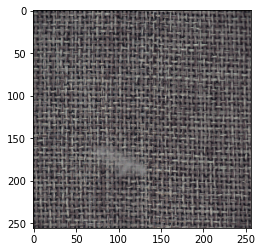

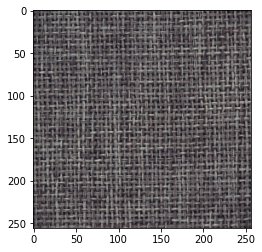

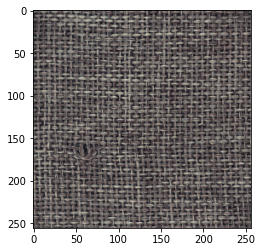

In [114]:
# Grab a few for testing
visImages = np.empty((3, DIM, DIM, 3))
visImages[0] = np.expand_dims(add_stain(trainX[0]).astype('float32') / 255, axis=0)
visImages[1] = np.expand_dims(valX[0], axis=0).astype('float32') / 255
test = cv2.imread(testImg)
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test, (256, 256))
visImages[2] = np.expand_dims(test, axis=(0)).astype('float32') / 255
plt.imshow(visImages[0])
plt.show()
plt.imshow(visImages[1])
plt.show()
plt.imshow(visImages[2])
plt.show()
visData = tf.data.Dataset.from_tensor_slices(visImages).batch(3)

[INFO] building autoencoder...
Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 128, 128, 96 1841984     input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16, 16, 576)  1661184     functional_1[0][4]               
__________________________________________________________________________________________________
add (Add)                       (None, 16, 16, 576)  0           sequential[0][0]                 
                                                         

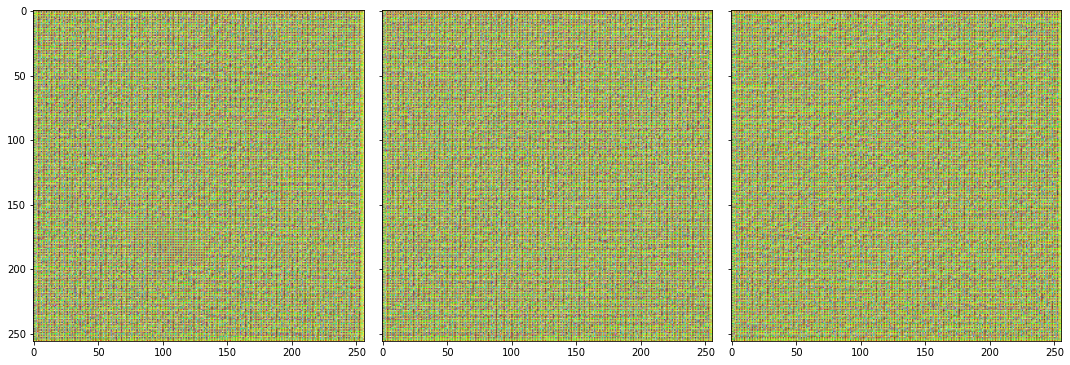


Sample Prediction after epoch 1

Epoch 1/1000
28/28 [==============================] - 33s 1s/step - loss: 0.0354 - val_loss: 0.0191
Epoch 2/1000
28/28 [==============================] - 32s 1s/step - loss: 0.0096 - val_loss: 0.0133
Epoch 3/1000
28/28 [==============================] - 32s 1s/step - loss: 0.0060 - val_loss: 0.0137
Epoch 4/1000
 2/28 [=>............................] - ETA: 13s - loss: 0.0051

In [ ]:
# from keras_adabound import AdaBound

print('[INFO] building autoencoder...')
K.clear_session()
# autoencoder=TutorialUnet(3)
autoencoder = create_autoencoder()  
lr_schedule = tf.keras.experimental.CosineDecay(
    initial_learning_rate=INIT_LR,
    decay_steps=EPOCHS * trainX.shape[0] // BS)
opt=Adam(learning_rate=lr_schedule)
autoencoder.compile(loss=LOSS, optimizer=opt)


'''
ADABOUND
'''
# WEIGHT_DECAY = 1e-6
# regularizer = tf.keras.regularizers.l2(WEIGHT_DECAY / 2)
# for layer in autoencoder.layers:
#     for attr in ['kernel_regularizer', 'bias_regularizer']:
#         if hasattr(layer, attr) and layer.trainable:
#             setattr(layer, attr, regularizer)
            
# autoencoder.compile(optimizer = AdaBound(lr=INIT_LR, final_lr=0.1),
#               loss = 'mse')
''''''
autoencoder.summary()

# callbacks=[
#     TensorBoard(
#     log_dir=args['output_path'], histogram_freq=0, write_graph=True, write_images=False,
#     update_freq='epoch', profile_batch=2, embeddings_freq=0,
#     embeddings_metadata=None)   
# ]
def show_predictions(model, inputs, preds):
    prediction = model.predict(inputs)
    fig, axes = plt.subplots(1, preds, sharex=True, sharey=True, figsize=(15,15))
    for i in range(preds):
        axes[i].imshow(prediction[i], cmap=plt.get_cmap('Greys_r'))
    plt.tight_layout()
    plt.show()
    
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch % 50 == 0:
            show_predictions(self.model, visImages, 3)
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

print('[INFO] training autoencoder...')
H=autoencoder.fit(
    trainData,
    validation_data=valData,
    epochs=EPOCHS,
    callbacks=[DisplayCallback()]
)

print('Saving...')
autoencoder.save(modelSavePath)